In [25]:
import pandas as pd


In [26]:
possible_dfs = [
    "wisconsin.csv", "compas_complete.csv", "coupon_full.csv", "wine_quality.csv",
    "broward_general_2y.csv", 'fico_complete.csv', 'iris_setosa.csv', 'iris_versicolor.csv',
    'iris_virginica.csv', 'monk.csv', 'spiral.csv', 'tic-tac-toe.csv', 'netherlands.csv'
]
result_list = []
db = 4
for dataset in possible_dfs:
    for lam in [0.02]:
        df_name = f"{dataset.split('.')[0]}_100_resamples_triv_ext_True_db{db}_reg_{lam}_rashomon_bound_adder_0.02"
        try:
            next_df = pd.read_csv(f"../rid_plots_1_22/{df_name}/summary.csv")
            next_df["dataset"] = dataset
            next_df["lam"] = lam
            result_list.append(next_df)
        except:
            print(f"Skipping {dataset}, {lam}")
            continue

all_results = pd.concat(result_list, axis=0)

Skipping monk.csv, 0.02


In [20]:
def nicify_dataset(row):
    match row['dataset']:
        case "wisconsin.csv":
            return "Wisconsin"
        case "coupon_full.csv":
            return "Coupon"
        case "compas_complete.csv":
            return "COMPAS"
        case "broward_general_2y.csv":
            return "Broward"
        case 'fico_complete.csv':
            return "FICO"
        case _:
            return ' '.join(row['dataset'].split('.')[0].split('_')).title()
all_results['dataset_nice'] = all_results.apply(
    lambda x: nicify_dataset(x),
    axis=1
)

In [24]:
print(all_results.shape)
print(all_results[
    (all_results['original_rid_max'] > 1e-6) | (all_results['corrected_rid_max'] > 1e-6)
].shape)

(217, 12)
(69, 12)


## Generate data for supplement table

In [21]:
print(all_results[
    (all_results['original_rid_max'] > 1e-6) | (all_results['corrected_rid_max'] > 1e-6)
][['dataset_nice', 'var', 'ks_test_stat', 'ks_test_p']].sort_values(["dataset_nice", 'var']).to_latex(index=False))

\begin{tabular}{llrr}
\toprule
dataset_nice & var & ks_test_stat & ks_test_p \\
\midrule
Broward & age_at_current_charge & 0.006845 & 0.973439 \\
Broward & age_at_first_charge & 0.028369 & 0.000685 \\
Broward & one_year & 0.009685 & 0.738680 \\
Broward & p_arrest & 0.020327 & 0.033135 \\
Broward & p_charges & 0.025376 & 0.003370 \\
Broward & p_dui & 0.010082 & 0.692329 \\
Broward & p_fta_two_year & 0.011583 & 0.516924 \\
Broward & p_misdemeanor & 0.049235 & 0.000000 \\
Broward & p_pending_charge & 0.008679 & 0.847098 \\
Broward & six_month & 0.009828 & 0.722117 \\
Broward & three_year & 0.037849 & 0.000001 \\
COMPAS & age & 0.043373 & 0.000016 \\
COMPAS & juvenile_crimes & 0.048217 & 0.000001 \\
COMPAS & priors_count & 0.067886 & 0.000000 \\
Coupon & CoffeeHouse1 & 0.067603 & 0.000035 \\
Coupon & coupon0 & 0.066138 & 0.000056 \\
Coupon & coupon2 & 0.065475 & 0.000069 \\
Coupon & coupon3 & 0.118504 & 0.000000 \\
Coupon & destination0 & 0.023984 & 0.490088 \\
Coupon & expiration1 & 0.028

### Make the large grid of RID plots

In [40]:
import os
from PIL import Image
from pdf2image import convert_from_path

var_to_img = {}
for dataset in tqdm(all_results['dataset'].unique()):
    df_name = f"{dataset.split('.')[0]}_100_resamples_triv_ext_True_db4_reg_0.02_rashomon_bound_adder_0.02"
    current_dir = f"../rid_plots_1_22/{df_name}/"
    for file in os.listdir(current_dir):
        if file == "summary.csv":
            continue
        else:
            var_to_img[file.split('_alt')[0].split("comparison_")[1]] = convert_from_path(current_dir + file)[0]

kept_images = []
for ind, row in all_results.iterrows():
    if row['ks_test_p'] < 0.05:
        if row['var'] in var_to_img:
            kept_images.append(var_to_img[row['var']])

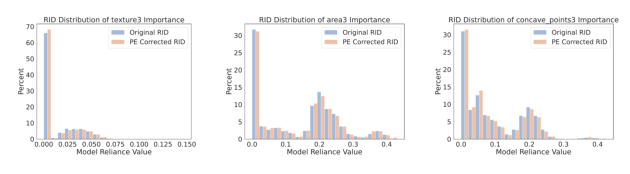

In [59]:
from matplotlib import pyplot as plt
from math import ceil

fig, axes = plt.subplots(nrows=ceil(len(kept_images) / 3), ncols=3, figsize=(4, ceil(len(kept_images) / 3)))

for i, ax in tqdm(enumerate(axes.flat)):
    ax.axis('off')
    if i >= len(kept_images):
        continue
    ax.imshow(kept_images[i])

fig.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig("./big_rid_grid_alt.pdf", dpi=600)